## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Show how long th test has been going

In [3]:
df.timestamp.min()

'2017-01-02 13:42:05.378582'

In [4]:
df.timestamp.max()

'2017-01-24 13:41:54.460509'

it seems that is been going for 22 days

b. Use the below cell to find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [7]:
df.query('converted == 1').shape[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
df.query('group == "treatment" and landing_page == "old_page"').shape[0] + df.query('group == "control" and landing_page == "new_page"').shape[0]



3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No missing values

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now drop the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page** .  Store your new dataframe in **df2**.

In [10]:
df.drop(df.query('group == "treatment" and landing_page == "old_page"').index, inplace=True)
df.drop(df.query('group == "control" and landing_page == "new_page"').index, inplace=True)
df2 = df

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2.**

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
df[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop(2893,inplace=True)

`4.` Use **df2** in the below cells.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.query('converted == 1').shape[0] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_control = df2.query('group == "control" and converted == 1').shape[0] / df2.query('group == "control"').shape[0]
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_treatment = df2.query('group == "treatment" and converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]
p_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer:** <br/>
>The result based on previous steps shows the control group has probability of conversion  as 12.04% which is higher than the treatment group which got 11.88%. <br/>
There are no big difference between the two groups so we can't say for certainty that one converts more users. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer:** <br/>
> Null:         **$p_{new}$** - **$p_{old}$** <= 0 <br/>
> Alternative: **$p_{new}$** - **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.query('converted == 1').shape[0] / df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.query('converted == 1').shape[0] / df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old =df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0, 1], n_new, p=[p_new, 1 - p_new])
new_page_converted.mean()

0.8803454683091322

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0, 1], n_old, p=[p_old, 1 - p_old])
old_page_converted.mean()

0.8802882828310641

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

5.718547806810026e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
p_diffs = []
for _ in range(10000):
    new = np.random.choice([0, 1], n_new, p=[p_new, 1 - p_new])
    old = np.random.choice([0, 1], n_old, p=[p_old, 1 - p_old])
    p_diffs.append(new.mean() - old.mean())
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

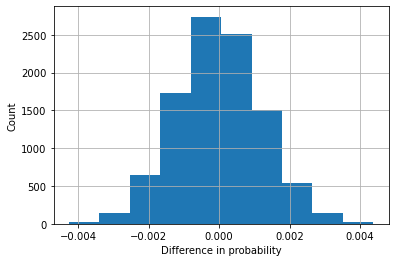

In [28]:
plt.hist(p_diffs);
plt.xlabel('Difference in probability');
plt.ylabel('Count');
plt.grid()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
actual_diff = p_treatment - p_control
(p_diffs > actual_diff).mean()

0.9047

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** <br/>
> What computed in part **j** was the difference of the simulated  difference and the actual difference. <br/>
The calculated value called p-value. <br/>
That means the p-value exceeds the 0.05 in this case **we fail to reject the null,** so the new page doesn't convert more users. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

The link above doesn't work so I searched for other sourse and found [This](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html)

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:** <br/>
> The p-value is about the same as we got from the previous step. <br/>
 The z-score shows how far the data point from the mean based on the z-score that we got it is less than the z-score for 95% confidence interval which is equal to 1.96 [source](https://www.alchemer.com/resources/blog/how-to-calculate-confidence-intervals/) so again **we fail to reject the null.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**
> Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1

df2['ab_page'] = pd.get_dummies(df2['group']).treatment
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = lm.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-10-18 12:03 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer:**
> ab_page p-value 0.1899 it differ from part II because in part II we assumed there are an equal chances to convert users from the old_page and new_page

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:** <br/>
> There are many other factors that might influenced the user such as age, gender, and time spent in the page. <br/>
It's better to take into consideration  other factors that might influence the user to convert. <br/>
Disadvantages of adding terms is that might lead to overfitting.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
# reading countery csv and join the dataframe with the old dataframe
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [36]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
# use US as baseline
df_new.drop(columns='US', inplace=True)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [37]:
df_new['ab_page_CA'] = df_new['ab_page'] * df_new['CA']
df_new['ab_page_UK'] = df_new['ab_page'] * df_new['UK']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,ab_page_CA,ab_page_UK
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [38]:
### Fit Your Linear Model And Obtain the Results
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'ab_page_CA', 'ab_page_UK']])
result = lm.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-10-18 12:03 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page_CA   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_page_UK    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

> All the variables have none significant p-value. thus again **we fail to reject the null**

<a id='conclusions'></a>
## Conclusions

> The old page is still slightly better than the new page so **we failed to reject the null.** <br/>
I found this conclusion in many test that showed that there are no significant evidence that suggest the new page is better 



In [39]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1